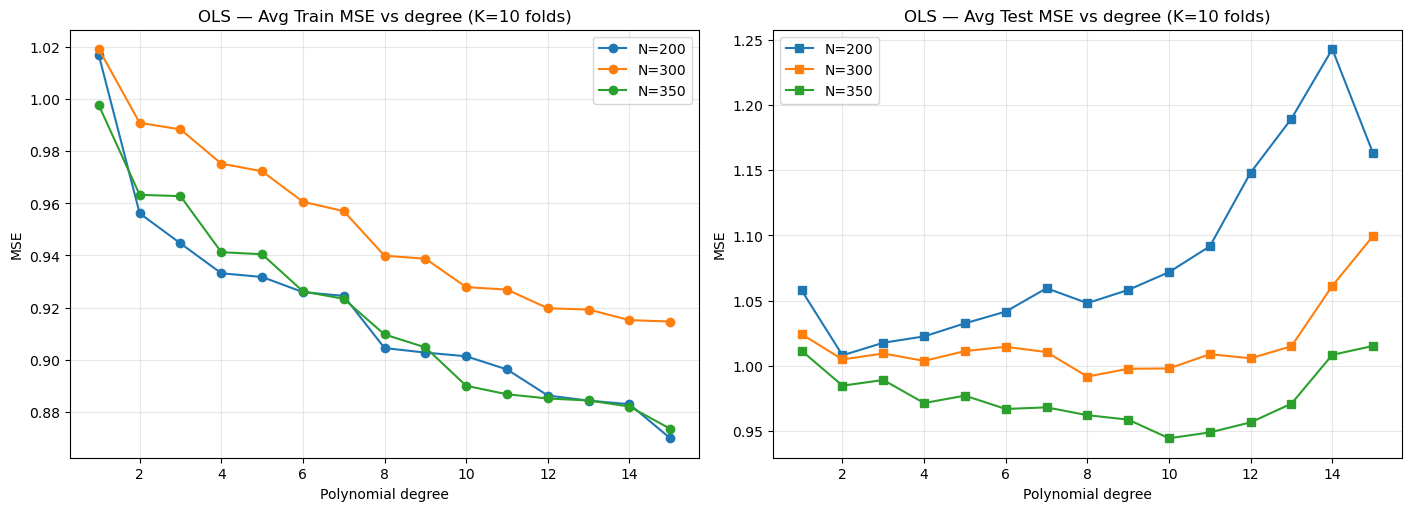

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from mlmods.data_utils import runge, prepare_design_from_indices
from mlmods.metrics_utils import mse
from mlmods.resampling_utils import kfold_indices

SEED = 3155
np.random.seed(SEED)

N_list = [200, 300, 350]
degree_range = range(1, 16)
K = 10

curves_train_k, curves_test_k = {}, {}

for N in N_list:
    x = np.random.uniform(-1, 1, size=N)
    y_true = runge(x)
    y = y_true + np.random.normal(0, 1, size=N)

    folds = kfold_indices(N, K, shuffle=True, seed=SEED)

    mean_train_curve, mean_test_curve = [], []
    for d in degree_range:
        fold_train_mse, fold_test_mse = [], []
        for k in range(K):
            te = folds[k]
            tr = np.concatenate([folds[j] for j in range(K) if j != k])

            # Center features for OLS; intercept added AFTER
            X_tr, X_te, y_tr, y_te = prepare_design_from_indices(x, y, d, tr, te, mode="center")

            theta = np.linalg.pinv(X_tr) @ y_tr
            fold_train_mse.append(mse(y_tr, X_tr @ theta))
            fold_test_mse.append(mse(y_te, X_te @ theta))

        mean_train_curve.append(float(np.mean(fold_train_mse)))
        mean_test_curve.append(float(np.mean(fold_test_mse)))

    curves_train_k[N] = mean_train_curve
    curves_test_k[N]  = mean_test_curve


# ---- Plot: two columns (Avg Train / Avg Test), multiple lines (one per N) ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# Column 1: Avg Train MSE (across folds)
ax = axes[0]
for N in N_list:
    ax.plot(list(degree_range), curves_train_k[N], marker='o', label=f"N={N}")
ax.set_title(f"OLS — Avg Train MSE vs degree (K={K} folds)")
ax.set_xlabel("Polynomial degree")
ax.set_ylabel("MSE")
ax.grid(True, alpha=0.3)
ax.legend()

# Column 2: Avg Test MSE (across folds)
ax = axes[1]
for N in N_list:
    ax.plot(list(degree_range), curves_test_k[N], marker='s', label=f"N={N}")
ax.set_title(f"OLS — Avg Test MSE vs degree (K={K} folds)")
ax.set_xlabel("Polynomial degree")
ax.set_ylabel("MSE")
ax.grid(True, alpha=0.3)
ax.legend()

plt.savefig("K-fold.pdf")
plt.show()